In [62]:
# Reload the evaluation module using ipython magic func
%load_ext autoreload
%autoreload 2


import pandas as pd
import sklearn
import statsmodels as sm
import numpy as np
import sktime

from typing import List

from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split

from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.model_evaluation import evaluate

from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from autots import AutoTS

from helpers import evaluation 

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Work Based Project
Initial Development Notebook

## Plan
1. Load the data
2. Clean the data
3. Reshape, resample (turn from monthly to quarterly)
4. Specify our model
5. Fit model
6. Predict
7. Evaluation (rolling OOS)



### Step 1: Load the data

In [2]:
input_data_dict = pd.read_excel('input data.xlsx', sheet_name=None)

for sheet_name, df in input_data_dict.items():
    print(f"Sheet name: {sheet_name}")

Sheet name: Instructions
Sheet name: dep
Sheet name: mind
Sheet name: quarterly
Sheet name: mserv
Sheet name: mprod
Sheet name: mconst
Sheet name: weights
Sheet name: GDP - low-level aggregates


### Step 2: Clean the data

In [3]:
# This is the first estimate of Quarterly GDP each quarter, turned into a time series
qgdp = input_data_dict['dep']

qgdp.index = pd.to_datetime(qgdp['Date'])
qgdp = qgdp.drop(['Date'], axis=1)
qgdp = qgdp.dropna()
qgdp = qgdp.rename(columns={'gdp': 'Quarterly GDP growth'})

qgdp.info()
qgdp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Quarterly GDP growth  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


,Quarterly GDP growth
Date,
1990-03-31,0.462645
1990-06-30,0.990487
1990-09-30,-1.282870
1990-12-31,-0.928221
1991-03-31,-0.470855


In [4]:
# Monthly indicators
m_ind = input_data_dict['mind']

m_ind.index = pd.to_datetime(m_ind['Date'])
m_ind = m_ind.drop(['Date'], axis=1)
m_ind = m_ind.dropna()

m_ind

,cipsto,cipste,cipstn,cbito,cbite,lbbba
Date,,,,,,
2003-10-31,59.019121,72.009759,57.887877,-8.0,8.0,53.0
2003-11-30,59.032192,74.245034,59.223734,2.0,15.0,38.0
2003-12-31,58.246338,75.003468,58.332699,7.0,18.0,62.0
2004-01-31,59.260138,76.271992,60.703809,20.0,29.0,53.0
2004-02-29,58.443636,73.355040,58.819207,18.0,33.0,55.0
...,...,...,...,...,...,...
2024-01-31,52.900000,70.600000,52.200000,-11.0,3.0,58.0
2024-02-29,52.979231,74.968075,52.261940,-6.0,5.0,52.0
2024-03-31,52.900000,73.800000,52.000000,-12.0,11.0,55.0


In [5]:
# Quarterly indicators
q_ind = input_data_dict['quarterly']

q_ind.index = pd.to_datetime(q_ind['Date'])
q_ind = q_ind.drop(['Date'], axis=1)
# q_ind = q_ind.dropna()

q_ind.info()
q_ind.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bccto   137 non-null    float64
 1   bccte   137 non-null    float64
 2   bcctn   137 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


,bccto,bccte,bcctn
Date,,,
1990-03-31,18.123964,41.704425,16.628885
1990-06-30,9.697203,40.272566,7.574371
1990-09-30,-2.484248,25.056637,-7.316107
1990-12-31,-8.483257,15.192920,-16.487859
1991-03-31,-23.884248,20.056637,-25.688354


In [6]:
# monthly GDP services
m_serv = input_data_dict['mserv']

m_serv.index = pd.to_datetime(m_serv['Date'])
m_serv = m_serv.drop(['Date'], axis=1)

m_serv = m_serv.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_serv = m_serv.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_serv.loc[m_serv.index < pd.Timestamp("August 2000")]
m_serv = m_serv.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_serv.columns) < pd.Timestamp("August 2000")
m_serv = m_serv.drop(m_serv.loc[:, columns_to_drop].columns, axis=1)

m_serv.info()
m_serv.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.9,1.0,1.0,1.0,1.0,1.1,1.1,1.1,1.1,1.1,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
2000-09-30,NaN,-0.3,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,...,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6
2000-10-31,NaN,NaN,0.1,0.0,0.1,0.2,0.2,0.2,0.2,0.2,...,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
2000-11-30,NaN,NaN,NaN,0.7,0.9,0.6,0.6,0.6,0.6,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


In [7]:
# monthly GDP production
m_prod = input_data_dict['mprod']

m_prod.index = pd.to_datetime(m_prod['Date'])
m_prod = m_prod.drop(['Date'], axis=1)

m_prod = m_prod.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_prod = m_prod.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_prod.loc[m_prod.index < pd.Timestamp("August 2000")]
m_prod = m_prod.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_prod.columns) < pd.Timestamp("August 2000")
m_prod = m_prod.drop(m_prod.loc[:, columns_to_drop].columns, axis=1)

m_prod.info()
m_prod.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.6,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259
2000-09-30,NaN,-1.1,-1.0,-1.0,-0.9,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952
2000-10-31,NaN,NaN,-0.2,-0.2,0.0,-0.1,-0.1,-0.1,-0.1,-0.1,...,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371
2000-11-30,NaN,NaN,NaN,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208


In [8]:
# monthly GDP construction
m_const = input_data_dict['mconst']

m_const.index = pd.to_datetime(m_const['Date'])
m_const = m_const.drop(['Date'], axis=1)

m_const = m_const.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_const = m_const.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_const.loc[m_const.index < pd.Timestamp("August 2000")]
m_const = m_const.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_const.columns) < pd.Timestamp("August 2000")
m_const = m_const.drop(m_const.loc[:, columns_to_drop].columns, axis=1)

m_const.info()
m_const.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-11-30,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def rescale_weights(array_of_weights):
    """Rescales the weights to add up to 1"""
    return array_of_weights / sum(array_of_weights)

In [10]:
# Load the weights and transform to monthly from quarterly 
gdp_weights = input_data_dict['weights']

gdp_weights.index = pd.to_datetime(gdp_weights['Date'])
gdp_weights = gdp_weights.drop(['Date'], axis=1)
gdp_weights = gdp_weights.resample(rule='m').ffill()


gdp_weights = gdp_weights.apply(
    func=rescale_weights, # Function to apply
    axis=1, # Apply function to each row
    raw=True, # Pass the data as a array rather than series
    result_type='broadcast', # Keep the shape of the DF the same
)

# Reshape:
weights_to_drop = gdp_weights.loc[(gdp_weights.index < pd.Timestamp("August 2000")) | (gdp_weights.index > m_serv.index[-1])]
gdp_weights = gdp_weights.drop(weights_to_drop.index)

gdp_weights.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   w_serv   285 non-null    float64
 1   w_prod   285 non-null    float64
 2   w_const  285 non-null    float64
dtypes: float64(3)
memory usage: 8.9 KB


/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_11847/1878564410.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_weights = gdp_weights.resample(rule='m').ffill()


In [11]:
# combine services, production and construction with their weights, to form monthly GDP
m_gdp = m_serv.mul(gdp_weights['w_serv'], axis=0) + m_prod.mul(gdp_weights['w_prod'], axis=0)  + m_const.mul(gdp_weights['w_const'], axis=0)

m_gdp

,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.836115,0.872229,0.872229,0.872229,0.872229,0.950934,0.950934,0.950934,0.950934,0.950934,...,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086
2000-09-30,NaN,-0.470361,-0.291656,-0.291656,-0.270361,-0.249066,-0.249066,-0.249066,-0.249066,-0.249066,...,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853
2000-10-31,NaN,NaN,0.036115,-0.042590,0.078705,0.136115,0.136115,0.136115,0.136115,0.136115,...,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258
2000-11-30,NaN,NaN,NaN,0.572229,0.729639,0.493525,0.493525,0.493525,0.493525,0.493525,...,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498
2000-12-31,NaN,NaN,NaN,NaN,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,...,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.029768,-0.029768,-0.036048,-0.036048,-0.036048
2024-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.202036,0.268512,0.327646,0.327646
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110611,0.250904,0.250904


### Step 3: Reshape the data - without vintages first

In [12]:
# Resample the quarterly indicators
q_resampled_ind = q_ind.resample('ME').ffill()


In [13]:
test_df = m_ind.merge(
    q_ind.resample('ME').ffill(), 
    left_index=True, 
    right_index=True, 
    how='inner'
).merge(
    m_gdp[m_gdp.columns[-1]],
    left_index=True,
    right_index=True,
    how='inner'
)

X = test_df.rename({test_df.columns[-1]: 'm_gdp'}, axis=1)
X.index.freq = 'ME' # type: ignore

X

,cipsto,cipste,cipstn,cbito,cbite,lbbba,bccto,bccte,bcctn,m_gdp
Date,,,,,,,,,,
2003-10-31,59.019121,72.009759,57.887877,-8.0,8.0,53.0,18.263393,51.568142,12.295492,0.120688
2003-11-30,59.032192,74.245034,59.223734,2.0,15.0,38.0,18.263393,51.568142,12.295492,-0.377613
2003-12-31,58.246338,75.003468,58.332699,7.0,18.0,62.0,24.812861,52.704425,20.142929,0.653732
2004-01-31,59.260138,76.271992,60.703809,20.0,29.0,53.0,24.812861,52.704425,20.142929,-0.395276
2004-02-29,58.443636,73.355040,58.819207,18.0,33.0,55.0,24.812861,52.704425,20.142929,0.294394
...,...,...,...,...,...,...,...,...,...,...
2023-11-30,50.653180,68.219176,49.598571,-11.0,-3.0,56.0,10.992920,36.136283,6.516248,0.190622
2023-12-31,52.148343,69.694714,51.799516,-8.0,-6.0,51.0,12.813451,40.488495,6.939398,-0.036048
2024-01-31,52.900000,70.600000,52.200000,-11.0,3.0,58.0,12.813451,40.488495,6.939398,0.327646


In [14]:
Y =  qgdp.resample('ME').ffill()
Y = Y.loc[Y.index >= X.index[0]]
Y.index.freq = 'ME'

Y

,Quarterly GDP growth
Date,
2003-10-31,0.600193
2003-11-30,0.600193
2003-12-31,0.900025
2004-01-31,0.900025
2004-02-29,0.900025
...,...
2023-11-30,-0.030000
2023-12-31,-0.344673
2024-01-31,-0.344673


In [15]:
# Make the feature data into a single dataframe, called X


# Make the target into a single dataframe, called y



# Transform the data
    # Make sure they're the same length
    # Make sure they're all for the same dates
    # Make sure they're all the same frequency

# Split X and y, using temporal_train_test_split into X_train, X_test, y_train, y_test

# Define a model
# Following the exmaple, fit the model to y_train, X_train
# Predict using the model using X_test

# Evaluate the predictions using y_test and the R^2 score thingy

# Done! For now...

### Step 4: Specify our model

In [16]:
# model_test = AutoReg(
#     endog=y_train,
#     lags=[1, 2, 3, 4, 5, 6],
#     exog=X_train,
#     trend='ct',
#     seasonal=False,
# )

# model_test = model_test.fit()

# model_test.summary()

In [17]:
# # Capital AutoREG is the sktime one...
# model = AutoREG(
#     lags=6,
#     trend='c'
# )

# model.fit(
#     y=y_train,
#     X=X_train,
#     fh=9,
# )


In [18]:
forecaster = AutoREG(
    lags=6,
    trend='c'
)

cv_strat_3m = ExpandingWindowSplitter(
    fh=[1, 2, 3],
    initial_window=100,
    step_length=1,
)

cv_strat_6m = ExpandingWindowSplitter(
    fh=[4, 5, 6],
    initial_window=100,
    step_length=1,
)

cv_strat_9m = ExpandingWindowSplitter(
    fh=[7, 8, 9],
    initial_window=100,
    step_length=1,
)

results_1Q = evaluate(
    forecaster=forecaster, 
    y=Y, 
    cv=cv_strat_3m, 
    X=X,
    scoring=[
        MeanAbsoluteScaledError(),
        MeanSquaredError(square_root=True),
        MeanAbsolutePercentageError(symmetric=True),
    ]
)

/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/lukasalemu/Downloads/ls/envs/

<Axes: >

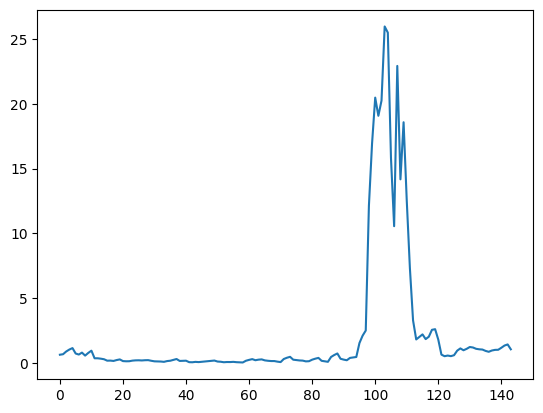

In [19]:
results_1Q['test_MeanSquaredError'].plot()

### Step 4.1: auto TS Model

In [20]:
# Specify model

model = AutoTS(
    forecast_length=3,
    model_list='fast',
    transformer_list='superfast',
    max_generations=4,
    num_validations=2,
    verbose=0,
    holiday_country='UK'
)

# Fit model - will pick the model 
model = model.fit(pd.concat([X, Y], axis=1))

/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 27 in generation 0: DatepartRegression
Template Eval Error: NameError("cannot access free variable 'Xf' where it is not associated with a value in enclosing scope") in model 53 in generation 0: GLM
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 58 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'xgboost'") in model 71 in generation 0: Cassandra
Template Eval Error: ValueError('Shape of weights must be consistent with shape of a along specified axis.') in model 72 in generation 0: BallTreeMultivariateMotif
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarnin

Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 79 in generation 0: WindowRegression
Template Eval Error: IndexError('tuple index out of range') in model 103 in generation 0: VAR
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 121 in generation 0: VECM
Template Eval Error: ModuleNotFoundError("No module named 'holidays'") in model 138 in generation 0: DatepartRegression
Template Eval Error: IndexError('tuple index out of range') in model 142 in generation 0: VAR
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 165 in generation 1: DatepartRegression
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 197 in generation 1: DatepartRegression
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 219 in generation 1: Wi

/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog

Template Eval Error: ValueError('Shape of weights must be consistent with shape of a along specified axis.') in model 419 in generation 3: BallTreeMultivariateMotif
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 470 in generation 3: VECM
Template Eval Error: ValueError('negative dimensions are not allowed') in model 481 in generation 3: Cassandra
Template Eval Error: ValueError('maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.') in model 496 in generation 4: VAR
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 497 in generation 4: VECM
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 503 in generation 4: WindowRegression
Template Eval Error: ValueError('maxlags is too large for the number of observations and the number of equations. The largest model cannot be estim

In [21]:
model

Initiated AutoTS object with best model: 
VAR
{'fillna': 'rolling_mean', 'transformations': {'0': 'Slice', '1': 'MinMaxScaler', '2': 'DifferencedTransformer', '3': 'EWMAFilter'}, 'transformation_params': {'0': {'method': 100}, '1': {}, '2': {'lag': 1, 'fill': 'bfill'}, '3': {'span': 10}}}
{'regression_type': None, 'maxlags': 5, 'ic': 'aic'}
Validation: 0, 1, 2
SMAPE: 35.96705084349356, 52.51210836905931, 68.8536330195466
MAE: 2.1321097234182114, 1.7225656568953047, 2.3246283291973615
SPL: 0.26067255746332185, 0.21634505658638206, 0.2868778842148974

In [87]:
Y

,Quarterly GDP growth
Date,
2003-10-31,0.600193
2003-11-30,0.600193
2003-12-31,0.900025
2004-01-31,0.900025
2004-02-29,0.900025
...,...
2023-11-30,-0.030000
2023-12-31,-0.344673
2024-01-31,-0.344673


In [88]:
wrapped_model = evaluation.ModelWrapper(
    model, 
    model_type='autots', 
    target_column_name='Quarterly GDP growth'
)

Wrapped Model: 
 Initiated AutoTS object with best model: 
VAR
{'fillna': 'rolling_mean', 'transformations': {'0': 'Slice', '1': 'MinMaxScaler', '2': 'DifferencedTransformer', '3': 'EWMAFilter'}, 'transformation_params': {'0': {'method': 100}, '1': {}, '2': {'lag': 1, 'fill': 'bfill'}, '3': {'span': 10}}}
{'regression_type': None, 'maxlags': 5, 'ic': 'aic'}
Validation: 0, 1, 2
SMAPE: 35.96705084349356, 52.51210836905931, 68.8536330195466
MAE: 2.1321097234182114, 1.7225656568953047, 2.3246283291973615
SPL: 0.26067255746332185, 0.21634505658638206, 0.2868778842148974


### Step 5: Fit the model

In [120]:
evaluator = evaluation.Evaluator()

eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=X,
    targets=Y,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7
)

Running evaluation over expanding blocks: 100%|██████████| 74/74 [00:00<00:00, 131.13it/s]


### Step 6: Predict using our model

In [121]:
eval_results

{'scores': [0.2076212297733435,
  0.2473540754280621,
  0.3273417941526899,
  0.24740902619811933,
  0.2469211426018895,
  0.15963044982540267,
  0.1428405410960599,
  0.2528088300275344,
  0.3075400406668626,
  0.24687309990859882,
  0.4067992495539694,
  0.24187260105122552,
  0.31297230243645785,
  0.3326254884885983,
  0.3846067536444676,
  0.4957812735608673,
  0.6496825240078318,
  0.46500810639917456,
  0.5768766111921035,
  0.5910595879848338,
  0.24914104683795613,
  0.37381570205574555,
  0.2130560946094225,
  1.0871213008451972,
  1.5297168095038134,
  1.9737306116199915,
  9.632772357617267,
  12.194879610570046,
  18.12063361770058,
  25.4450327297423,
  23.957683287904366,
  34.80411995621292,
  18.21164666359861,
  13.116410579026113,
  7.355569215249192,
  2.9220444358195703,
  2.853868170700107,
  2.0620593391436497,
  3.81890261647802,
  5.105755911584401,
  4.900617005499576,
  2.909894174898502,
  3.0459601048828575,
  3.580900210821598,
  0.44961511295733725,
  0.5

Text(0.5, 1.0, 'RMSE over time for the model')

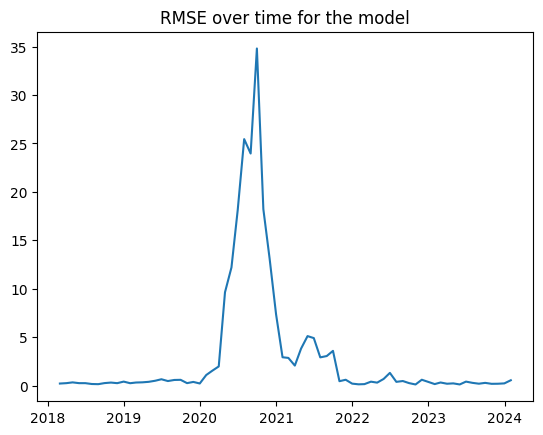

In [122]:
eval_scores = [x for x in eval_results['scores']]
eval_dates = pd.to_datetime([x.index[0] for x in eval_results['predictions']])
plt.plot(eval_dates, eval_scores)
plt.title('RMSE over time for the model')

In [ ]:
# Fix the preds for charting - prepend the y_date value to the series

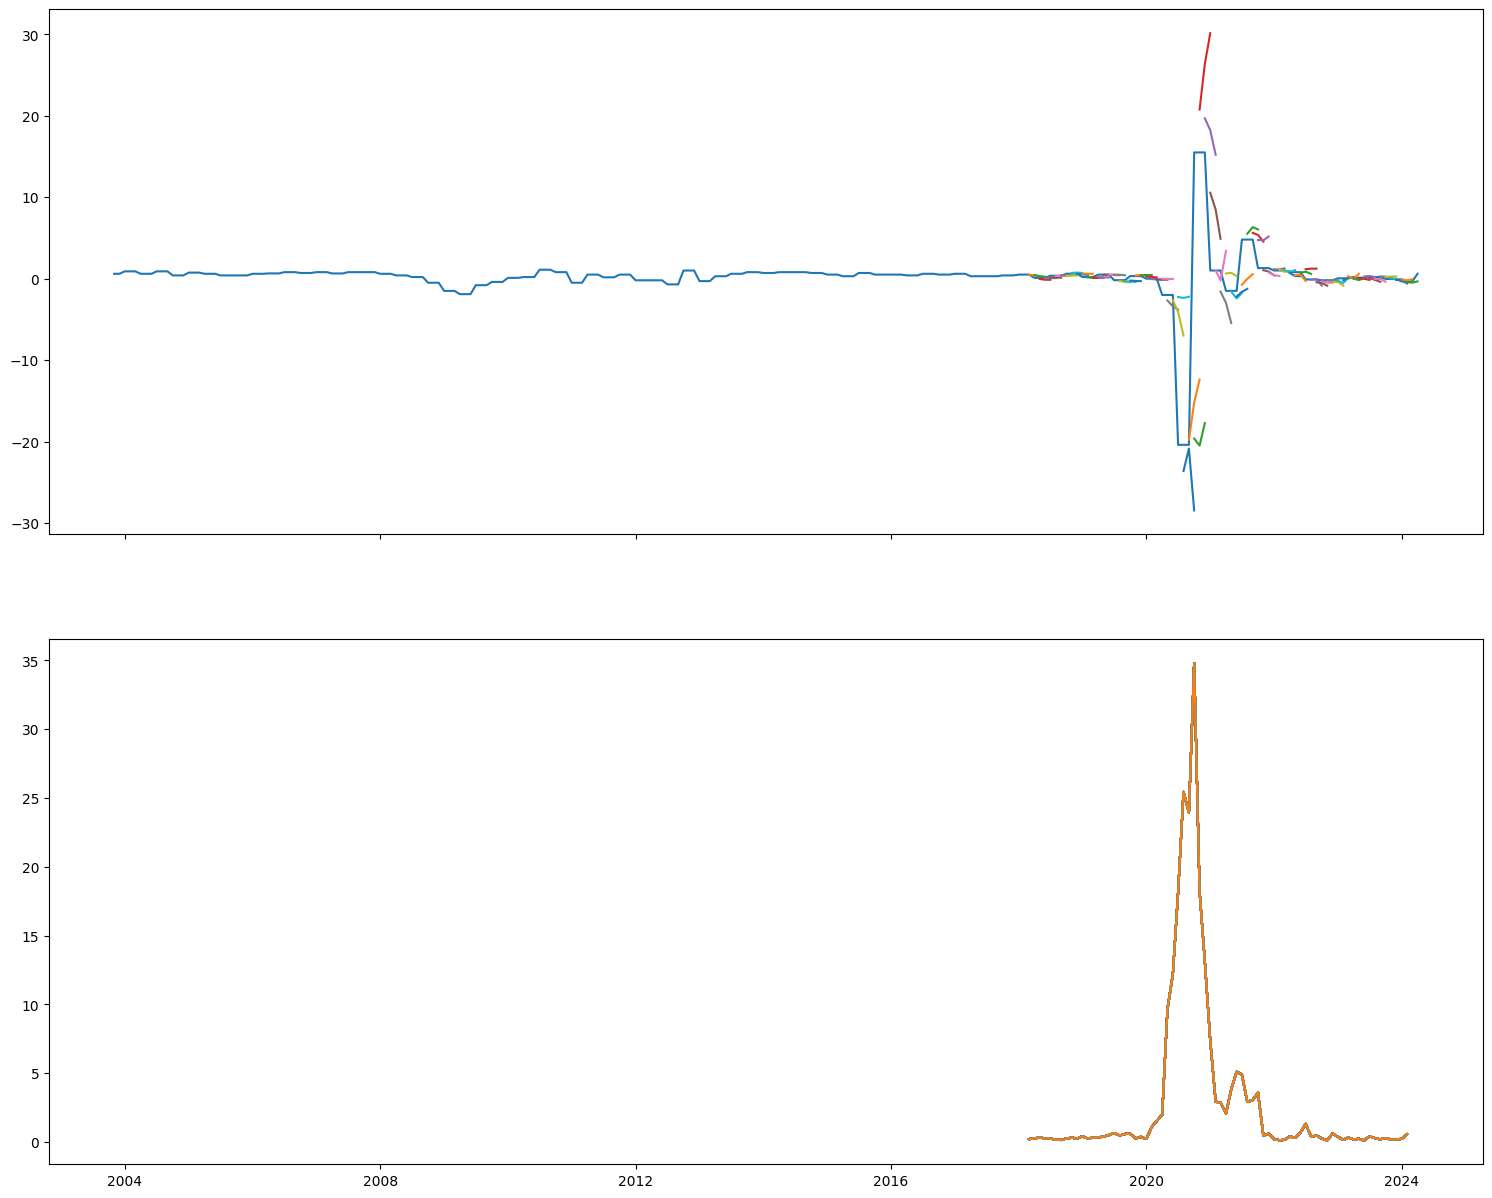

In [105]:
# Plot the backforecasts
fig, (ax, ax1) = plt.subplots(2,1, sharex=True)
ax.plot(Y)

for scores, preds in zip(eval_results['scores'], eval_results['predictions']): 
    ax.plot(preds)
    ax1.plot(eval_dates, eval_scores)
    
# Make the chart figure way bigger
fig.set_size_inches(18.5, 15)

### Step 7: OOS Evaluation
Combine the previous steps into a single loop, moving through each month and storing the results